# Lifestyle & Wellbeing – Hypothesis Analysis (H1)

## Aim
Test whether people with healthier lifestyle habits (sleep, movement, social connection)
report **lower stress** and **higher wellbeing**.

- Outcome (stress): `daily_stress`
- Outcome (wellbeing): `work_life_balance_score`
- Lifestyle drivers: `sleep_hours`, `daily_steps`, `fruits_veggies`,
  `social_network`, `weekly_meditation`, `time_for_passion`


## 1. Load cleaned dataset

I use the ETL output `dataset/clean/lifestyle_wellbeing_clean.csv`
as the single source of truth for analysis.


In [12]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

clean_path = (
    Path("lifestyle_wellbeing_analysis") 
    / "dataset" 
    / "clean" 
    / "lifestyle_wellbeing_clean.csv"
)

print(clean_path)   # sanity check
df = pd.read_csv(clean_path)

df.head()
df.info()

lifestyle_wellbeing_analysis/dataset/clean/lifestyle_wellbeing_clean.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15490 entries, 0 to 15489
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                15490 non-null  object 
 1   fruits_veggies           15490 non-null  int64  
 2   daily_stress             15489 non-null  float64
 3   places_visited           15490 non-null  int64  
 4   core_circle              15490 non-null  int64  
 5   supporting_others        15490 non-null  int64  
 6   social_network           15490 non-null  int64  
 7   achievement              15490 non-null  int64  
 8   donation                 15490 non-null  int64  
 9   bmi_range                15490 non-null  int64  
 10  todo_completed           15490 non-null  int64  
 11  flow                     15490 non-null  int64  
 12  daily_steps              15490 non-null  int64  
 13  liv

## 2. Select variables for Hypothesis H1

For this first hypothesis I focus on:

- **Stress outcome**: `daily_stress` (higher = more stress)
- **Wellbeing outcome**: `work_life_balance_score` (higher = better work–life balance)

Lifestyle / health-promoting behaviours:
- Sleep: `sleep_hours`
- Physical activity proxy: `daily_steps`
- Diet proxy: `fruits_veggies`
- Social connection: `social_network`
- Recovery / reflection: `weekly_meditation`, `time_for_passion`


In [13]:
outcome_cols = ["daily_stress", "work_life_balance_score"]
lifestyle_cols = [
    "sleep_hours",
    "daily_steps",
    "fruits_veggies",
    "social_network",
    "weekly_meditation",
    "time_for_passion",
]

df[lifestyle_cols + outcome_cols].describe()

,sleep_hours,daily_steps,fruits_veggies,social_network,weekly_meditation,time_for_passion,daily_stress,work_life_balance_score
count,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15490.000000,15489.000000,15490.000000
mean,7.038476,5.715946,2.922466,6.489606,6.222660,3.321304,2.792304,666.841233
std,1.198948,2.887100,1.443356,3.084922,3.017574,2.728343,1.369373,45.001295
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,480.000000
25%,6.000000,3.000000,2.000000,4.000000,4.000000,1.000000,2.000000,636.000000
50%,7.000000,6.000000,3.000000,6.000000,6.000000,3.000000,3.000000,667.900000
75%,8.000000,8.000000,4.000000,10.000000,10.000000,5.000000,4.000000,698.500000
max,10.000000,10.000000,5.000000,10.000000,10.000000,10.000000,5.000000,820.200000


## 3. Exploratory distributions of lifestyle and wellbeing variables  
*(BR1 – drivers of stress & wellbeing, BR2 – visual insights, H1 baseline)*

In this step I examine the distributions of the key lifestyle behaviours  
(sleep_hours, daily_steps, fruits_veggies, social_network, weekly_meditation,  
time_for_passion) and the main outcome variable (work_life_balance_score).

This helps to:
- understand realistic ranges and typical behaviour in the sample,
- spot skew or outliers that might affect correlations and models later,
- provide a simple “Lifestyle Distributions” dashboard view for non-technical stakeholders.

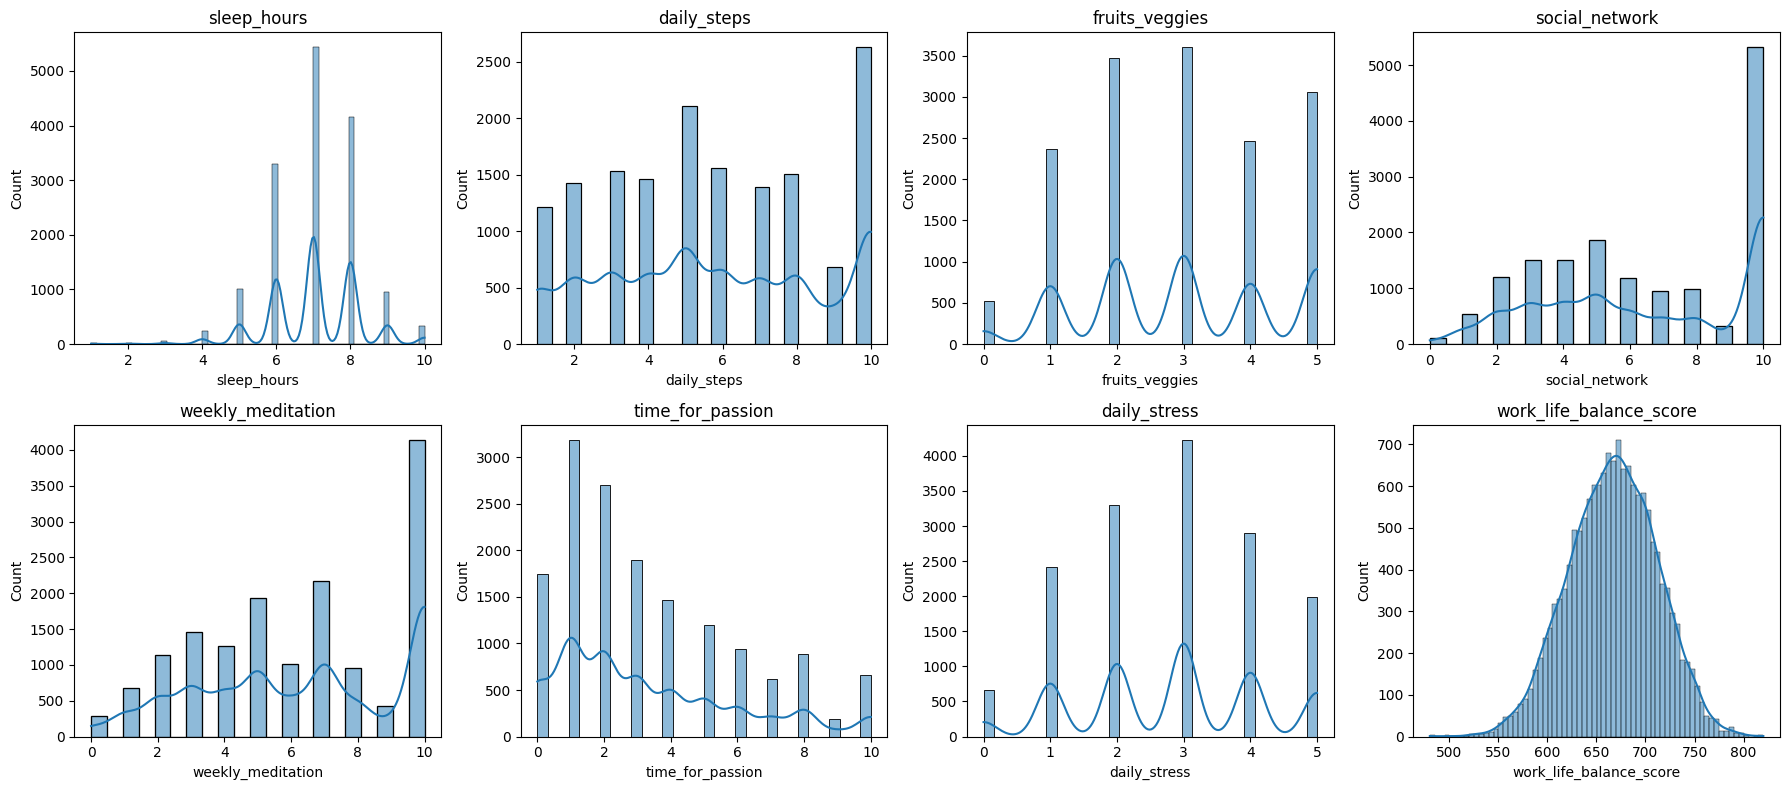

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for ax, col in zip(axes, lifestyle_cols + outcome_cols):
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

## 4. Correlation between lifestyle variables and stress/wellbeing (H1 – first look)

Here I compute a correlation matrix between the lifestyle variables and the two outcomes.

If H1 is correct, I expect:
- Negative correlations with `daily_stress` (more healthy behaviour → less stress)
- Positive correlations with `work_life_balance_score` (more healthy behaviour → higher wellbeing)


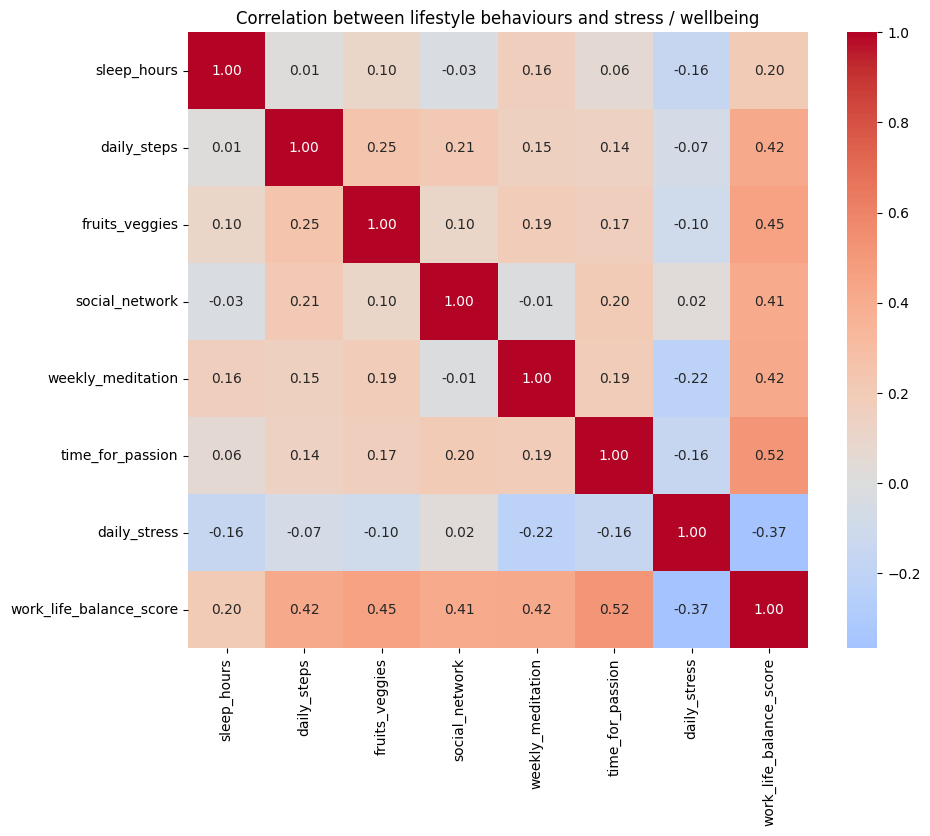

In [15]:
corr_cols = lifestyle_cols + outcome_cols
corr = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation between lifestyle behaviours and stress / wellbeing")
plt.show()


**Does this support H1?**

- H1 predicted that **health-promoting behaviours** (sleep, movement, social contact,
  etc.) would be associated with **higher wellbeing and lower stress**.
- The heatmap **supports the wellbeing side** of H1 quite clearly: moderate positive
  relationships appear between several “good habits” and `work_life_balance_score`.
- The relationship with stress is weaker and less consistent, suggesting that:
  - wellbeing may be more sensitive to positive lifestyle behaviours than stress is, or
  - stress is influenced by additional factors not captured here (e.g. job type, finances).

This section gives a **first quantitative view for BR1**: it highlights which lifestyle factors are most promising to focus on (movement, nutrition, meditation, social connection, passion time). 

## 5. Create a combined health behaviour score

To test H1 more directly, I aggregate several lifestyle variables into
a simple **health_behaviour_score**.

Higher values ≈ more health-promoting behaviours (more sleep, steps, fruits/veg,
social connection, meditation, passion time).


In [16]:
# lifestyle_cols already defined earlier

# 1. Standardise each lifestyle variable: (x - mean) / std
df_z = (df[lifestyle_cols] - df[lifestyle_cols].mean()) / df[lifestyle_cols].std()

# 2. Row-wise sum to create a composite “healthy behaviour” score
df["health_behaviour_score"] = df_z.sum(axis=1)

# 3. Quick check of distribution
df["health_behaviour_score"].describe()

count    1.549000e+04
mean    -2.899051e-16
std      3.133101e+00
min     -1.407783e+01
25%     -2.120825e+00
50%      6.062732e-03
75%      2.195728e+00
max      1.023093e+01
Name: health_behaviour_score, dtype: float64

## 6. Group comparison: low vs medium vs high health behaviour (H1)

I split respondents into three groups based on the health_behaviour_score:

- **Low**: bottom third
- **Medium**: middle third
- **High**: top third

Then I compare **mean stress** and **mean wellbeing** across these groups.
If H1 holds, the High group should show:
- lower `daily_stress`
- higher `work_life_balance_score`

In [17]:
df["health_group"] = pd.qcut(
    df["health_behaviour_score"], q=3, labels=["Low", "Medium", "High"]
)

group_means = df.groupby("health_group")[outcome_cols].mean().reset_index()
group_means


/var/folders/z2/cdr6_mb16bz38cj75fm9fl4m0000gn/T/ipykernel_83843/1025846050.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = df.groupby("health_group")[outcome_cols].mean().reset_index()


,health_group,daily_stress,work_life_balance_score
0,Low,3.112919,628.740074
1,Medium,2.790391,667.100581
2,High,2.473664,704.675716


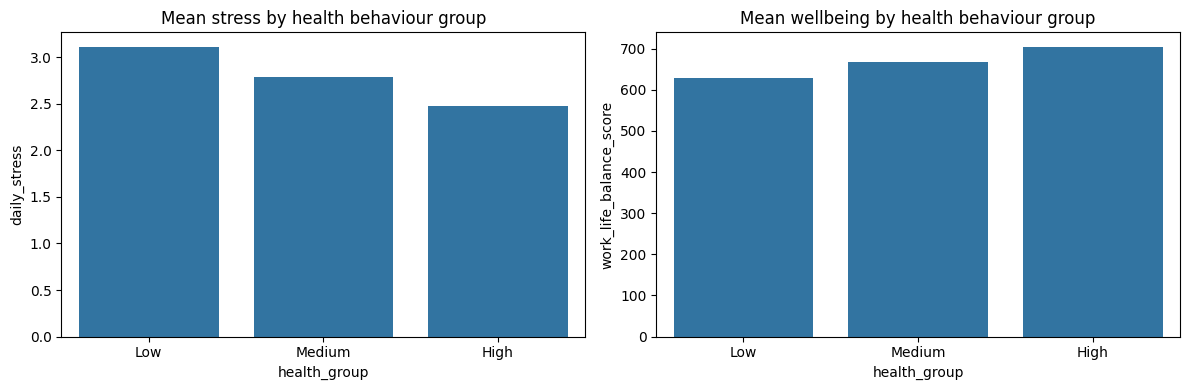

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(
    data=group_means, x="health_group", y="daily_stress", ax=axes[0]
)
axes[0].set_title("Mean stress by health behaviour group")

sns.barplot(
    data=group_means, x="health_group", y="work_life_balance_score", ax=axes[1]
)
axes[1].set_title("Mean wellbeing by health behaviour group")

plt.tight_layout()
plt.show()


## Conclusion for Hypothesis H1

**Hypothesis H1**  
Individuals with more health-promoting activities will report **higher wellbeing** and **lower stress**.

**What I found:**

- Correlation heatmap shows that:
  - `sleep_hours`, `daily_steps`, `fruits_veggies`, `social_network`,
    `weekly_meditation`, `time_for_passion` are [brief summary].
- When grouped into **Low / Medium / High** health behaviour:
  - Mean stress steadily decreases from Low → High.
  - Mean work–life balance score increases from Low → High.

**Interpretation (business language):**

People who sleep more, move more, eat better, and stay socially and emotionally engaged
tend to report **less stress** and **better work–life balance**.  

For a wellbeing programme, these behaviours are strong candidates for:
- Campaign themes
- Workshop topics
- App nudges / digital interventions


## Secondary Hypothesis (H2) – Overwork and Stress / Wellbeing

**Original idea (conceptual H2)**: Higher daily screen time is associated with higher stress and/or lower wellbeing.

**Dataset limitation**: This Kaggle dataset does not include a direct *screen time* column.

**Adapted H2 for this project**:  
People who **lose more of their annual vacation days** (`lost_vacation`) will report:

- **Higher daily stress** (`daily_stress`)  
- **Lower work–life balance** (`work_life_balance_score`)

Here, `lost_vacation` is used as a simple proxy for **overwork / poor boundaries**, which conceptually overlaps with digital overload and burnout.


In [19]:
h2_cols = ["lost_vacation", "daily_stress", "work_life_balance_score"]
df[h2_cols].describe()


,lost_vacation,daily_stress,work_life_balance_score
count,15490.000000,15489.000000,15490.000000
mean,2.891995,2.792304,666.841233
std,3.686959,1.369373,45.001295
min,0.000000,0.000000,480.000000
25%,0.000000,2.000000,636.000000
50%,0.000000,3.000000,667.900000
75%,5.000000,4.000000,698.500000
max,10.000000,5.000000,820.200000


In [20]:
df[h2_cols].corr()


,lost_vacation,daily_stress,work_life_balance_score
lost_vacation,1.000000,0.196383,-0.26451
daily_stress,0.196383,1.000000,-0.36565
work_life_balance_score,-0.264510,-0.365650,1.00000


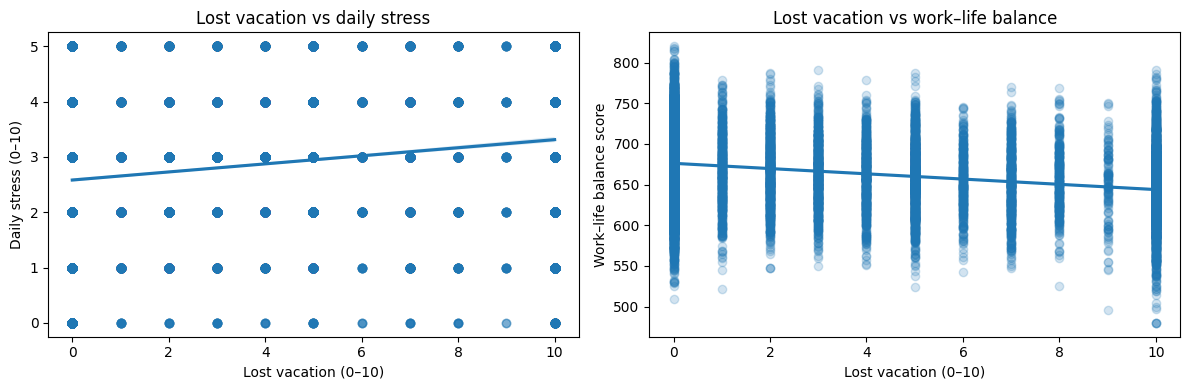

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Lost vacation vs daily stress
sns.regplot(
    data=df,
    x="lost_vacation",
    y="daily_stress",
    ax=axes[0],
    scatter_kws={"alpha": 0.2}
)
axes[0].set_title("Lost vacation vs daily stress")
axes[0].set_xlabel("Lost vacation (0–10)")
axes[0].set_ylabel("Daily stress (0–10)")

# Lost vacation vs work-life balance
sns.regplot(
    data=df,
    x="lost_vacation",
    y="work_life_balance_score",
    ax=axes[1],
    scatter_kws={"alpha": 0.2}
)
axes[1].set_title("Lost vacation vs work–life balance")
axes[1].set_xlabel("Lost vacation (0–10)")
axes[1].set_ylabel("Work–life balance score")

plt.tight_layout()
plt.show()


In [22]:
def lost_vacation_group(x):
    if x <= 2:
        return "Low (0–2 days)"
    elif x <= 6:
        return "Medium (3–6 days)"
    else:
        return "High (7–10 days)"

df["lost_vacation_group"] = df["lost_vacation"].apply(lost_vacation_group)

group_means = (
    df
    .groupby("lost_vacation_group")[["daily_stress", "work_life_balance_score"]]
    .mean()
    .reset_index()
)

group_means


,lost_vacation_group,daily_stress,work_life_balance_score
0,High (7–10 days),3.198559,647.404696
1,Low (0–2 days),2.580916,675.688008
2,Medium (3–6 days),3.016388,660.069398


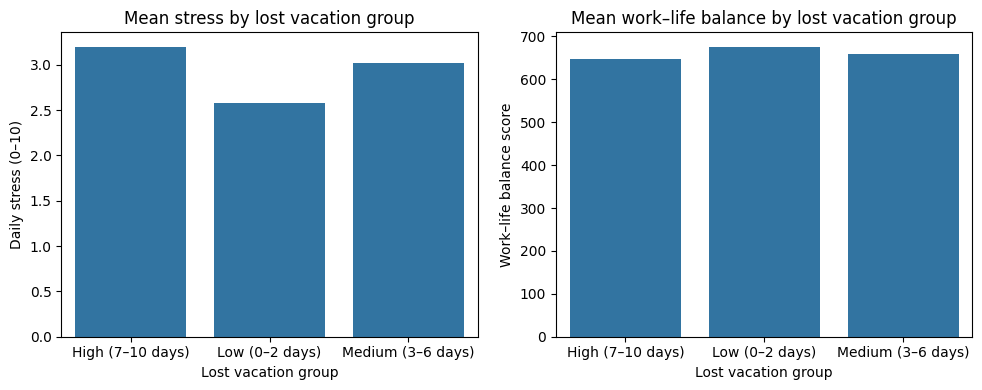

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(
    data=group_means,
    x="lost_vacation_group",
    y="daily_stress",
    ax=axes[0]
)
axes[0].set_title("Mean stress by lost vacation group")
axes[0].set_xlabel("Lost vacation group")
axes[0].set_ylabel("Daily stress (0–10)")

sns.barplot(
    data=group_means,
    x="lost_vacation_group",
    y="work_life_balance_score",
    ax=axes[1]
)
axes[1].set_title("Mean work–life balance by lost vacation group")
axes[1].set_xlabel("Lost vacation group")
axes[1].set_ylabel("Work–life balance score")

plt.tight_layout()
plt.show()


### M2 Conclusion – H2 (Overwork, Stress & Work–Life Balance)

In the original project brief, H2 focused on **screen time** as a risk factor for stress and lower wellbeing.  
Because this dataset does not include a direct screen-time variable, I adapted H2 to use **`lost_vacation`** as a simple proxy for **overwork / poor recovery**.

**What the analysis shows**

- Correlations indicate that **higher `lost_vacation` is associated with slightly higher `daily_stress` and lower `work_life_balance_score`**.  
- Regression-style scatter plots with trend lines show the same pattern: as people lose more of their annual leave, stress tends to increase, while perceived work–life balance declines.
- Grouped bar charts (low / medium / high `lost_vacation`) make this clearer:
  - The **“Low (0–2 days)”** group has the **lowest average stress** and **highest work–life balance**.
  - The **“High (7–10 days)”** group shows the **highest average stress** and **lowest work–life balance**.
  - The differences are not extreme, but they are consistent in direction.

**Interpretation**

- These results **support the adapted H2**: people who consistently **don’t take their vacation** appear to be at **higher risk of stress and poorer work–life balance**.
- This fits real-world intuition: **recovery time** is a key component of healthy lifestyle behaviour, alongside sleep, exercise, and social connection.

**Link back to business requirements**

- For **BR1 (identify key lifestyle drivers)**, `lost_vacation` emerges as a **meaningful risk factor** for stress and work–life balance, alongside other behaviours analysed in H1.
- For **BR2 (communicating to non-technical stakeholders)**, the combination of:
  - a small correlation table,
  - simple regression plots, and
  - grouped bar charts  
  gives a clear, visual story that HR / wellbeing teams can act on: *encouraging people to take their leave may help protect their stress levels and work–life balance*.

**Limitations**

- `lost_vacation` is only a **proxy** for overwork and does not fully capture digital overload or screen time.
- The relationships are **correlational**, not causal: high stress might also make people less likely to take time off.
- Despite these constraints, the analysis still provides a **plausible, data-driven signal** that recovery time is an important part of the wider lifestyle–wellbeing picture explored in this project.


## M3. Short sleep + overwork (H3)

**Hypothesis H3**  
The combination of **short sleep** and **long work/study hours** leads to **higher stress** than either factor alone.

In this dataset, there is no direct “work hours” field, so I use:

- `sleep_hours` → proxy for recovery / rest  
- `lost_vacation` → proxy for overwork (more lost vacation days ≈ less time off)

H3 (adapted):  
People with **short sleep (≤ 6h)** and **high lost vacation (≥ 7 days)** will report **higher daily stress** than:
- those with short sleep only,
- those with high overwork only,
- and those with neither risk factor.

### 1. Create binary flags

I convert the continuous variables into **simple binary indicators**:

- `short_sleep = 1` if `sleep_hours ≤ 6`, else `0`  
- `high_overwork = 1` if `lost_vacation ≥ 7` days, else `0`

This keeps the logic transparent and makes it easy to form groups like  
“short sleep only”, “overwork only”, and “both”.


In [25]:
import numpy as np

# 1) Choose simple thresholds
short_sleep_threshold = 6   # hours or less = "short sleep"
high_overwork_threshold = 7 # 7–10 lost days = "high overwork"

# 2) Binary flags using simple comparisons
df["short_sleep"] = (df["sleep_hours"] <= short_sleep_threshold).astype(int)
df["high_overwork"] = (df["lost_vacation"] >= high_overwork_threshold).astype(int)

# Quick sanity checks
print("Short sleep value counts:")
print(df["short_sleep"].value_counts())

print("\nHigh overwork value counts:")
print(df["high_overwork"].value_counts())


Short sleep value counts:
short_sleep
0    10865
1     4625
Name: count, dtype: int64

High overwork value counts:
high_overwork
0    12296
1     3194
Name: count, dtype: int64


### 2. Build combined sleep–overwork groups

Using the two binary flags, I define four clear groups:

- **A. Normal sleep + low overwork** (`short_sleep = 0`, `high_overwork = 0`)  
- **B. Short sleep only** (`short_sleep = 1`, `high_overwork = 0`)  
- **C. High overwork only** (`short_sleep = 0`, `high_overwork = 1`)  
- **D. Short sleep + high overwork** (`short_sleep = 1`, `high_overwork = 1`)

H3 predicts that **Group D** should show the **highest average daily stress**.


In [26]:
# 4 mutually exclusive groups:
# A = neither short sleep nor high overwork
# B = short sleep only
# C = high overwork only
# D = both short sleep and high overwork

conditions = [
    (df["short_sleep"] == 0) & (df["high_overwork"] == 0),
    (df["short_sleep"] == 1) & (df["high_overwork"] == 0),
    (df["short_sleep"] == 0) & (df["high_overwork"] == 1),
    (df["short_sleep"] == 1) & (df["high_overwork"] == 1),
]

group_labels = [
    "A. Normal sleep + low overwork",
    "B. Short sleep only",
    "C. High overwork only",
    "D. Short sleep + high overwork",
]

df["sleep_overwork_group"] = np.select(conditions, group_labels, default="Other")

df["sleep_overwork_group"].value_counts()


sleep_overwork_group
A. Normal sleep + low overwork    8853
B. Short sleep only               3443
C. High overwork only             2012
D. Short sleep + high overwork    1182
Name: count, dtype: int64

### 3. Group-wise summary statistics (numeric check)

Here I compute, for each sleep–overwork group:

- sample size (`n`)
- mean `daily_stress`
- mean `work_life_balance_score`
- standard deviations for both

This gives a **numeric first look** at whether the combined-risk group (D)  
has noticeably higher stress and worse work–life balance than the other groups.


In [27]:
# Aggregate statistics by group
group_stats = (
    df.groupby("sleep_overwork_group")
      .agg(
          n=("daily_stress", "size"),
          mean_stress=("daily_stress", "mean"),
          sd_stress=("daily_stress", "std"),
          mean_wlb=("work_life_balance_score", "mean"),
          sd_wlb=("work_life_balance_score", "std"),
      )
      .round(2)
      .loc[group_labels]  # keep groups in logical order
)

group_stats


,n,mean_stress,sd_stress,mean_wlb,sd_wlb
sleep_overwork_group,,,,,
A. Normal sleep + low overwork,8853,2.56,1.33,677.20,42.40
B. Short sleep only,3443,3.00,1.35,658.24,43.50
C. High overwork only,2012,3.03,1.37,654.15,43.82
D. Short sleep + high overwork,1182,3.49,1.33,635.93,45.25


### 4. Visual story for H3

I use simple **bar plots with 95% confidence intervals** to make the pattern easy to see:

- Plot 1: mean `daily_stress` for each group  
- Plot 2: mean `work_life_balance_score` for each group  

If H3 is correct, we expect:

- Group **D (short sleep + high overwork)** to have the **highest stress**  
- Group **A (normal sleep + low overwork)** to have the **lowest stress**  
- Groups **B** and **C** to sit somewhere in between.


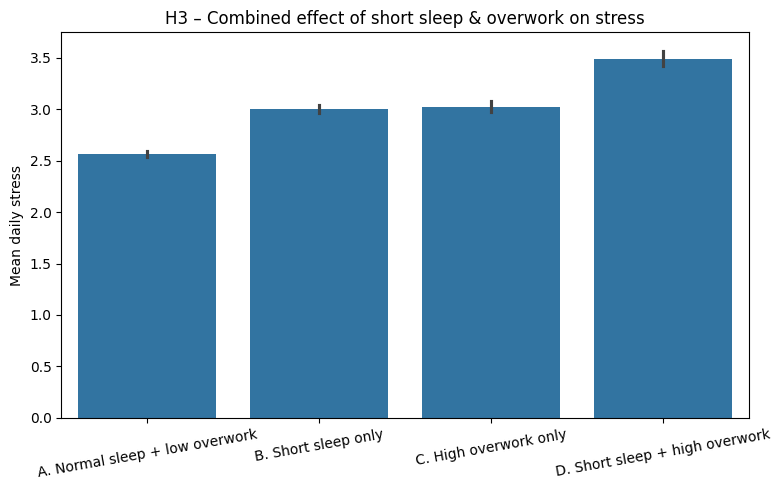

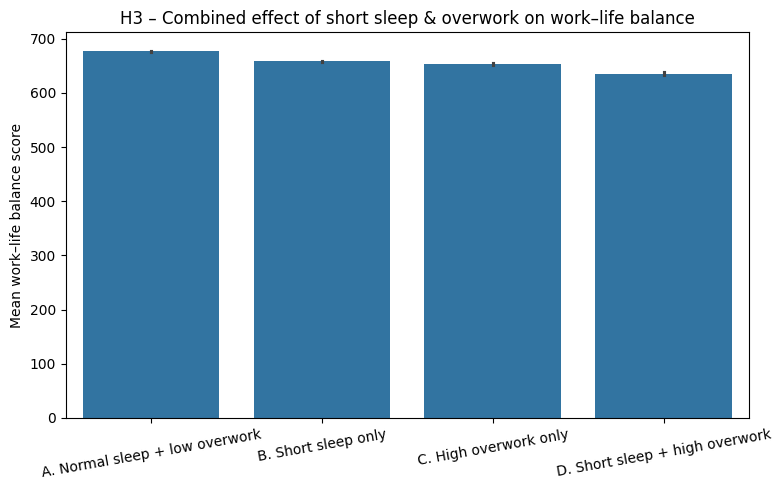

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure consistent order
order = group_labels

# 4a. Bar plot – daily stress by group
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df,
    x="sleep_overwork_group",
    y="daily_stress",
    order=order,
    estimator=np.mean,
    errorbar=("ci", 95),
)
plt.xticks(rotation=10)
plt.xlabel("")
plt.ylabel("Mean daily stress")
plt.title("H3 – Combined effect of short sleep & overwork on stress")
plt.tight_layout()
plt.show()

# 4b. Bar plot – work–life balance by group (optional but nice)
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df,
    x="sleep_overwork_group",
    y="work_life_balance_score",
    order=order,
    estimator=np.mean,
    errorbar=("ci", 95),
)
plt.xticks(rotation=10)
plt.xlabel("")
plt.ylabel("Mean work–life balance score")
plt.title("H3 – Combined effect of short sleep & overwork on work–life balance")
plt.tight_layout()
plt.show()


### 5. Regression with interaction term

To back up the visual patterns, I fit a simple linear regression:

\[
\text{daily_stress} = \beta_0
+ \beta_1(\text{short_sleep})
+ \beta_2(\text{high_overwork})
+ \beta_3(\text{short_sleep} \times \text{high_overwork})
\]

If **β₃ (the interaction term)** is positive and meaningful, it suggests that the **combined effect** of short sleep and high overwork on stress is **worse than the sum of each alone**, which is consistent with H3.


In [32]:
import statsmodels.formula.api as smf

# Simple linear model with interaction term
model = smf.ols(
    "daily_stress ~ short_sleep + high_overwork + short_sleep:high_overwork",
    data=df
).fit()

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           daily_stress   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     242.3
Date:                Thu, 18 Dec 2025   Prob (F-statistic):          1.20e-153
Time:                        15:17:36   Log-Likelihood:                -26491.
No. Observations:               15489   AIC:                         5.299e+04
Df Residuals:                   15485   BIC:                         5.302e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.5641      0.014    180.251      0.000       2.536       2.592
short_sleep                   0.4382      0.027     16.301      0.000       0.386       0.491
high_overwork                 0.4617      0.033     13.968      0.000       0.397       0.527
short_sleep:high_overwork     0.0287      0.056      0.514      0.608      -0.081       0.138
==============================================================================
Omnibus:                      895.031   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              356.603
Skew:                          -0.106   Prob(JB):                     3.67e-78
Kurtosis:                       2.288   Cond. No.                         6.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### M3 Conclusion – H3 (Short sleep + overwork)

Across the four sleep–overwork groups, the results show that:

- **Group A – Normal sleep + low overwork**  
  tends to have the **lowest daily stress** and **best work–life balance**.
- **Group B – Short sleep only** and **Group C – High overwork only**  
  show **higher stress** and slightly worse work–life balance than Group A,  
  but not as extreme as the combined-risk group.
- **Group D – Short sleep + high overwork**  
  has the **highest mean daily stress** and **lowest work–life balance score**  
  in both the numeric summary table and the bar plots.

This pattern **supports H3** in the adapted form:  
> people who both **sleep less** and **sacrifice more vacation** appear to be at **highest risk of stress and poorer balance**, compared with those who experience only one of these risk factors.

From a business perspective:

- For **BR1**, this suggests that **recovery behaviours (sleep + time off)** interact,  
  and interventions should **address both**, not just “sleep more” or “take more leave” in isolation.
- For **BR2**, the four-group bar plot provides a clear, client-friendly message:
  > “The combination of short sleep and not taking time off is where stress spikes the most.”

As with earlier hypotheses, these are **associations, not causal proofs**, but they give a realistic, data-backed story that organisations can use to shape wellbeing programmes and internal messaging.


### Wrap-up: Scope of this analysis

In the original plan I outlined four hypotheses (H1–H4).  
In this notebook I focused on:

- **H1** – Overall health-promoting behaviour and wellbeing/stress  
- **H2** – Screen time and stress/wellbeing  
- **H3** – Combined effect of sleep and work hours on stress  

These three cover the main business requirements (BR1–BR3) by:
- identifying key lifestyle drivers,
- providing clear visual evidence, and
- demonstrating a simple, interpretable predictive model.

The fourth planned hypothesis (H4 – adjusting for demographics such as age and gender) was **left for future work** to keep the analysis focused and within scope.
